### Please run MNIST_download.ipynb to download, pre-process, and store all the necessary data in mnist_dataset folder

In [1]:
!ls

IFT6135H19_A1_Pc.png		  mnist_dataset		mnist_experiments
IFT6135H19_Assignment_1_P1.ipynb  MNIST_download.ipynb


In [2]:
#!pip install git+https://github.com/agoose77/numpy-html.git#egg=numpy-html
#import numpy_html
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
#np.set_printoptions(threshold=5, edgeitems=2)

# Part-1,2,3) Multi-Layer Perceptron in Numpy

## A) Helper Function for Neural Network Implementation

### 1) Affine Layer Forward and Backward pass

In [3]:
def Affine_forward(inp, W, B):
  # Params, inp: Input to Layer : (NxD)
  #         W: weight of Layer  : (DxM)
  #         B  Bias of Layer    : (1xM)
  # Output, out = inp*W + B     : (NxM) 

  out = np.dot(inp,W) + B  # out: (NxD)x(D,M) + (1,M) = (N,M)

  return out

In [4]:
def Affine_backward(inp, W, B, gradient):
  # Assume, inp                         : (NxD)
  #         W                           : (DxM)
  #         B                           : (1XM)
  #         gradient                    : (NxM)
  #         reg regulazier scaler       : (1x1)  
  # Output, Dinp = gradient*Traspose(T) : (NxD)
  #         DW = Traspose(inp)*gradient : (NxD)
  #         DB = Sum_N gradient         : (1xM) 
  
  Dinp = np.dot(gradient, W.T)                  # DH: (NxM) * (MxD) = (NxD)
  DW = np.dot(inp.T, gradient)                # DW  : (DxN) * (NxM) = (DxM)
  DB = np.sum(gradient, 0, keepdims=True)     # DB  : Sum_N (N,M)   = (1xM)
    
  return Dinp, DW, DB
  

### 2) ReLU forward and backward Pass

In [5]:
def ReLU(inp):
  # Params, inp               : (N,M)
  # Output, activ = max(0,inp): (N,M)

  activ = np.maximum(0,inp)
  
  return np.maximum(0,inp)

In [6]:
def ReLU_backward(inp, gradient):
  # Params, inp: Input to ReLU                                             : (N,M)
  #         gradient: Backpropogating gradient from the next layer         : (N,M)
  # Output: gradient: gradient * Derivative of ReLU (1 if X>0 otherwise 0) : (N,M)
  
  gradient[inp<=0] = 0
  
  return gradient

### 3) Sigmoid Forward and Backward Pass

In [7]:
def Sigmoid(inp):
  # Params, inp                       : (N,M)
  # Output, activ = 1 / 1 + exp(-inp) : (N,M)
  
  activ = 1 / (1 + np.exp(-inp))
  
  return activ

In [8]:
def Sigmoid_backward(inp, gradient):
  # Params, inp: Input to ReLU                                                 : (N,M)
  #         gradient: Backpropogating gradient from the next layer             : (N,M)
  # Output: gradient: gradient * Derivative of Sigmoid (sigmoid * (1-sigmoid)) : (N,M)
 
  s = Sigmoid(inp)  
  Dsigmoid = s*(1-s)
  
  out = gradient * Dsigmoid
  
  return out

### 4) TanH Forward and Backward Pass

In [9]:
def TanH(inp):
  # Params, inp                                         : (N,M)
  # Output, activ = (exp(2*inp) - 1) / (exp(2*inp) + 1) : (N,M)
  
  exp2a = np.exp(2*inp)
  activ = (exp2a - 1) / (exp2a + 1)
  
  return activ

In [10]:
def TanH_backward(inp, gradient):
  # Params, inp: Input to TanH                                                 : (N,M)
  #         gradient: Backpropogating gradient from the next layer             : (N,M)
  # Output: gradient: gradient * Derivative of TanH (1-TanH^2))                : (N,M)

  tanh = TanH(inp)
  Dtanh = 1 - (tanh**2)
  
  out = gradient * Dtanh
  
  return out

### 5) SoftMax Forward and Backward Pass

In [11]:
def softmax(inp):
  # Params, inp                                        : (N,C)
  # Output, out: probs = exp(inp_i) / Sum_j exp(inp_j) : (N,C)
    
  exp_inp = np.exp(inp)
  probs = exp_inp / np.sum(exp_inp, axis=1, keepdims=True)
  
  return probs

In [12]:
def softmax_backward(probs, GT):
  # Params, probs: Network output probabilities                                                : (N,C)
  #         GT:  each value belongs to one of C classes                                        : (N,)
  # Output, Gradient of Pre-SoftMax activation with respect to output (dout = -(e(y) - probs)) : (N,C)          

  dout = probs
  dout[range(GT.shape[0]),GT] -= 1
  dout /= GT.shape[0]

  return dout

### 6) Cross-Entropy Loss

In [13]:
def cross_entropy_loss(probs, GT):
  # Params, probs: (N,C) where sum_c = 1
  #         GT   : (N,) 
  # Output, loss : scalar
  
  # compute log probability for true value of GT for each example
  logprobs = -np.log(probs[range(GT.shape[0]),GT])

  loss = np.sum(logprobs)
  loss /= GT.shape[0]

  return loss

### 7) Function to shuffle training data after epoch

In [14]:
def shuffle_data(X,Y):
   
  s = np.arange(X.shape[0])
  np.random.shuffle(s)

  return X[s], Y[s]

### 8) Saving and Loading python objects as pickle file

In [15]:
def save_obj(obj, path, name):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [16]:
def load_obj(path, name):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## B) Neural Network Class Implementation

### Note that NN class has a function named initialization which allows us to initialize NN with any initialization method (glorot, normal, or zero)

In [17]:
class NN(object):

  
  def __init__(self,
               input_dims=784, 
               output_dims=10, 
               hidden_dims=(1024,2048), 
               n_hidden=2, 
               regularization_coefficient=0,
               init_method='zeros',           # 'zeros', 'normal', or 'glorot'
               nonlinearity = 'relu',         # 'relu', 'tanh', or 'sigmoid'
               LearningRate = 0.001):
    
    dims = (input_dims,) + hidden_dims + (output_dims,)    
    self.n_hidden = n_hidden
     
    self.LR = LearningRate
    self.reg_coeff = regularization_coefficient
    
    self.params = {}    # dictionary of parameters of NN
    self.cache = {}     # dictionary of forward model cache
    self.gradient = {}  # dictionary of backward model cache (gradient)

    self.activ = nonlinearity
    self.initialize_weights(n_hidden, dims, init_method)
         
        
  def initialize_weights(self,n_hidden, dims, init_method):
    
    # W = weight parameters
    # B = Biases
    
    for i in range(1,n_hidden+2):
      
      self.params['B'+str(i)] = np.zeros((1,dims[i]))
      
      if init_method == 'zeros':
        self.params['W'+str(i)] = np.zeros((dims[i-1],dims[i]))
      elif init_method == 'normal':
        self.params['W'+str(i)] = np.random.normal(0.0, 1.0, (dims[i-1],dims[i]))        
      elif init_method == 'glorot':
        dl = np.sqrt(6/(dims[i-1]+dims[i]))
        self.params['W'+str(i)] = np.random.uniform(-dl, dl, (dims[i-1],dims[i]))
      else:
        raise Exception('Weight Intialization Method should be one of the following: zeros, glorot, or normal') 
    
    # DA = gradient of W
    # DB = gradient pf B
    for i in range(1,n_hidden+2):

      self.gradient['DB'+str(i)] = np.zeros((1,dims[i]))     
      self.gradient['DW'+str(i)] = np.zeros((dims[i-1],dims[i]))

        
  def activation(self,input):
    
    if self.activ == 'relu':
      out = ReLU(input)
    elif self.activ == 'tanh':
      out = TanH(input)
    elif self.activ == 'sigmoid':
      out = Sigmoid(input)
    else:
      raise Exception('NonLinearity should be one of the following: relu, tanh, or sigmoid')
        
    return out
        

  def activation_backward(self,input,gradient):
    
    if self.activ == 'relu':
      out = ReLU_backward(input, gradient)
    elif self.activ == 'tanh':
      out = TanH_backward(input, gradient)
    elif self.activ == 'sigmoid':
      out = Sigmoid_backward(input, gradient)
    else:
      raise Exception('NonLinearity should be one of the following: relu, tanh, or sigmoid')
        
    return out

  
  def forward(self,input):    
    
    # W = weight parameters
    # B = Biases
    # A = pre-activation (affine transformed input)
    # H = post-activation (Hidden layer output)

    self.cache['input'] = input
    self.cache['A1'] = Affine_forward(self.cache['input'], self.params['W1'], self.params['B1']) # A1 = X*W1 + B1

    for i in range(1,self.n_hidden+1):
      self.cache['H'+str(i)] = self.activation(self.cache['A'+str(i)]) # Hi = active(Ai), ex: H1=active(A1)
      self.cache['A'+str(i+1)] = Affine_forward(self.cache['H'+str(i)], self.params['W'+str(i+1)], self.params['B'+str(i+1)]) # A_(i+1) = H_(i)*W_(i+1) + B_(i+1), ex: A2 = H1*W2 + B2

    self.cache['out'] = softmax(self.cache['A'+str(self.n_hidden+1)]) # out = softmax(A3)
      
    return self.cache['out']

  
  def loss(self,prediction,labels):

    data_loss = cross_entropy_loss(prediction, labels)
    
    reg_loss = 0
    
    # if regularization parameter if greater than 0 than calculate L2 value of all weight layer to calculate reg_loss
    if self.reg_coeff>0:
      reg_loss = sum(np.sum(self.params['W'+str(i)]**2) for i in range(1,self.n_hidden+2))

    loss = data_loss + (self.reg_coeff * reg_loss)
    
    return loss
  
  
  def backward(self, labels):
    
    # DA is a dummy variable to store gradient of pre-activation
    # DH is a dummy variable to store gradient of post-pactivation

    DA = softmax_backward(self.cache['out'], labels) 
    
    for i in range(self.n_hidden+1, 1, -1):
      DH, self.gradient['DW'+str(i)], self.gradient['DB'+str(i)] =  Affine_backward(self.cache['H'+str(i-1)], self.params['W'+str(i)], self.params['B'+str(i)], DA) # DH2, DW3, DB3 = backward(H2, W3, B3)
      DA = self.activation_backward(self.cache['A'+str(i-1)], DH) #DA2 = backward(A2, DH2)
 
    _, self.gradient['DW1'], self.gradient['DB1'] = Affine_backward(self.cache['input'], self.params['W1'], self.params['B1'], DA) # Dinp, DW1, DB1 = backward(input, W1, B1, DA1)

     
  def update(self):
    
    # Update NN parameters
    
    for i in range(1,self.n_hidden+2):

      self.params['B'+str(i)] -= self.LR*self.gradient['DB'+str(i)] 
      
      if self.reg_coeff>0:
        self.gradient['DW'+str(i)] += self.reg_coeff * self.params['W'+str(i)]

      self.params['W'+str(i)] -= self.LR*self.gradient['DW'+str(i)]
  
  
  def zero_gradient(self):
    
    # make gradients zero
    # useful to do it at the starting of epocj

    for i in range(1,n_hidden+2):

      self.gradient['DB'+str(i)] = np.zeros(self.gradient['DB'+str(i)].shape)     
      self.gradient['DW'+str(i)] = np.zeros(self.gradient['DW'+str(i)].shape)
      
    
    
    

### Train function to train model for one epoch (pass through all training images)

In [18]:
def train(model, x_train, y_train, batch_size):
    
  samples = x_train.shape[0]

  epoch_loss = 0

  for i in range(0, samples, batch_size):
      
    data, label = x_train[i:i+batch_size], y_train[i:i+batch_size] # get batch of data and label
      
    pred_probs = model.forward(data) # forward pass of the data
      
    batch_loss = model.loss(pred_probs, label) # calculate loss with respect to label
      
    epoch_loss += batch_loss # increment epoch loss
      
    model.backward(label) # backward pass with respect to label
      
    model.update() # update model parameters
      
    model.zero_gradient() # make gradient zero
      
  epoch_loss = (epoch_loss * batch_size) / (samples) # normalize epoch loss with respect to batch size and total samples
    
  return epoch_loss


### Train function to get prediction for all test data and calculate loss and accuracy for this data

In [24]:
def test(model, x, y):

  model.zero_gradient() # make model gradient to zero
  
  samples = x.shape[0] # calculate total data samples
  
  epoch_loss = 0       # to store loss for the wholte dataset
  true_prediction = 0  # to store total true prediction
  
  for i in range(0, samples):
      
    data, label = x[i:i+1], y[i:i+1] # get a sample of data
      
    pred_probs = model.forward(data) # forward pass through model
    
    pred_labels = np.argmax(pred_probs) # find the predicted label
    
    batch_loss = model.loss(pred_probs, label) # calculate loss

    true_prediction += np.count_nonzero(pred_labels-label == 0) # check if prediction and true label are same or not
    
    epoch_loss += batch_loss # increment epoch loss
            
  epoch_loss = epoch_loss / samples # normalize loss with batch_size and samples
  
  accuracy = true_prediction / samples # calculate accuracy
  
  return epoch_loss, accuracy


## Neural Network parameters

In [20]:
# experiment parameters
total_epoch = 10

data_path = 'mnist_dataset/mnist.npy'
model_path = 'mnist_experiments/Exp_validate_gradient/'

os.makedirs(model_path,exist_ok=True)

input_dims=784 
output_dims=10 
hidden_dims=(512,1024) 
n_hidden=2 
regularization_coefficient=0
init_method ='glorot'          # 'zeros', 'normal', or 'glorot'
nonlinearity = 'relu'         # 'relu', 'tanh', or 'sigmoid'
LearningRate = 0.1

batch_size = 16

### Read MNIST data and pre-process it

In [21]:
# data-preparation
(tr, va, te) = np.load(data_path)
    
x_train = tr[0]
y_train = tr[1]
x_valid = va[0]
y_valid = va[1]
x_test  = te[0]
y_test  = te[1]
    
data_mean = x_train.mean()
data_std  = x_train.std()
    
x_train = (x_train - data_mean) / data_std 
x_test  = (x_test  - data_mean) / data_std 
x_valid = (x_valid - data_mean) / data_std 

del tr, va, te

## Initialize NN model

In [26]:
model = NN(input_dims, output_dims, hidden_dims, n_hidden, regularization_coefficient, init_method, nonlinearity, LearningRate)

model_params = sum(value.size for _, value in model.params.items())

print('Total Model Parameters: ', model_params)

Total Model Parameters:  937482


### Train the network for total_epochs and print and store training and validation loss and accuracy after each epoch

In [27]:
train_loss = []
valid_loss = []
  
train_accuracy = []
valid_accuracy = []

for i in range(1,total_epoch+1):
  
  loss = train(model, x_train, y_train, batch_size)
  
  print("===> Training Done Epoch {}".format(i))
  
  loss, accuracy = test(model, x_train, y_train)
  
  train_loss = np.concatenate((train_loss, [loss]))
  train_accuracy = np.concatenate((train_accuracy, [accuracy]))

  print("===> Training   Epoch {}: Loss - {:.4f}, Accuracy - {:.4f}".format(i, train_loss[-1], train_accuracy[-1]))

  loss, accuracy = test(model, x_valid, y_valid)
  
  valid_loss = np.concatenate((valid_loss, [loss]))
  valid_accuracy = np.concatenate((valid_accuracy, [accuracy]))

  print("===> Validation Epoch {}: Loss - {:.4f}, Accuracy - {:.4f}".format(i, valid_loss[-1], valid_accuracy[-1]))
  
  save_obj(model.params, model_path, 'model-{:02d}'.format(i))
  
  print("===> Model Saved Epoch {}".format(i))

  shuffle_data(x_train, y_train)

  
save_obj(train_loss, model_path, 'train-loss')
save_obj(train_accuracy, model_path, 'train-accuracy')
save_obj(valid_loss, model_path, 'valid-loss')
save_obj(valid_accuracy, model_path, 'valid-accuracy')


_, test_accuracy = test(model, x_test, y_test)

print("===> Testing Accuracy at the end of training: {:.4f}".format(test_accuracy) )

save_obj([test_accuracy], model_path, 'test-accuracy')


===> Training Done Epoch 1
===> Training   Epoch 1: Loss - 0.0969, Accuracy - 0.9692
===> Validation Epoch 1: Loss - 0.1185, Accuracy - 0.9651
===> Model Saved Epoch 1
===> Training Done Epoch 2
===> Training   Epoch 2: Loss - 0.0593, Accuracy - 0.9799
===> Validation Epoch 2: Loss - 0.1019, Accuracy - 0.9697
===> Model Saved Epoch 2
===> Training Done Epoch 3
===> Training   Epoch 3: Loss - 0.0371, Accuracy - 0.9882
===> Validation Epoch 3: Loss - 0.0862, Accuracy - 0.9747
===> Model Saved Epoch 3
===> Training Done Epoch 4
===> Training   Epoch 4: Loss - 0.0217, Accuracy - 0.9923
===> Validation Epoch 4: Loss - 0.0853, Accuracy - 0.9772
===> Model Saved Epoch 4
===> Training Done Epoch 5
===> Training   Epoch 5: Loss - 0.0465, Accuracy - 0.9862
===> Validation Epoch 5: Loss - 0.1171, Accuracy - 0.9733
===> Model Saved Epoch 5
===> Training Done Epoch 6
===> Training   Epoch 6: Loss - 0.0295, Accuracy - 0.9916
===> Validation Epoch 6: Loss - 0.1045, Accuracy - 0.9779
===> Model Saved 

# Part-4) Validate Gradient using finite difference at the end of training

### Get a single training data

In [28]:
data, label = x_train[1:2], y_train[1:2]
      
pred_probs = model.forward(data)
                  
model.backward(label)

### store original params W1

In [29]:
orig_W1 = model.params['W1']

### Define Maximum valur of i, j, and K

In [30]:
max_i = 10
max_j = 6
max_k = 5

Approx_delta = np.zeros((max_i, max_j, max_k)) #(10,6,5)

True_delta = model.gradient['DW1'][0][0:max_i]

True_delta = np.repeat(True_delta[:,np.newaxis],max_j,axis=-1)
True_delta = np.repeat(True_delta[:,:,np.newaxis],max_k,axis=-1)


### approximate gradient with finite difference

In [31]:
for i in range(0,max_i):
    for j in range(0,max_j):
        for k in range(0,max_k):
            N = (k+1)*(10**j)
            epsi = 1 / N
            ## positive
            model.params['W1'][0][i] += epsi
            pred_probs = model.forward(data)
            loss = model.loss(pred_probs, label)
            pos = loss
            model.params['W1'] = orig_W1
            ## negative
            model.params['W1'][0][i] -= epsi
            pred_probs = model.forward(data)
            loss = model.loss(pred_probs, label)
            neg = loss
            model.params['W1'] = orig_W1
            ## Approximate Delta
            Approx_delta[i][j][k] = (pos-neg) / (2*epsi)
            

### Calculate maximum difference between finite difference and true difference for difference values of N

In [32]:
N = np.zeros((max_j*max_k,))
max_diff = np.zeros((max_j*max_k,))

In [33]:
#print(Approx_delta[9][0][0])
#print(True_delta[9][0][0])
i = 0
for j in range(max_j):
    for k in range(max_k):
        N[i] = (k+1)*(10**j)
        max_diff[i] = np.max(True_delta[:,j,k] - Approx_delta[:,j,k])
        i = i+1
    

print(N)
print(max_diff)

[1.e+00 2.e+00 3.e+00 4.e+00 5.e+00 1.e+01 2.e+01 3.e+01 4.e+01 5.e+01
 1.e+02 2.e+02 3.e+02 4.e+02 5.e+02 1.e+03 2.e+03 3.e+03 4.e+03 5.e+03
 1.e+04 2.e+04 3.e+04 4.e+04 5.e+04 1.e+05 2.e+05 3.e+05 4.e+05 5.e+05]
[4.12914148e-15 3.96260802e-15 3.79607457e-15 3.85158572e-15
 4.01811917e-15 3.18545191e-15 3.18545191e-15 2.63034039e-15
 3.18545191e-15 2.07522888e-15 2.07522888e-15 0.00000000e+00
 7.62634400e-15 7.62634400e-15 7.62634400e-15 7.62634400e-15
 7.62634400e-15 7.62634400e-15 7.62634400e-15 7.62634400e-15
 7.62634400e-15 7.62634400e-15 7.62634400e-15 7.62634400e-15
 7.62634400e-15 7.62634400e-15 7.62634400e-15 7.62634400e-15
 7.62634400e-15 7.62634400e-15]


### Plot this value as a function of N

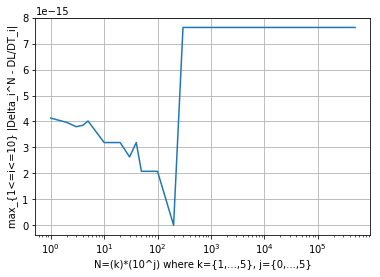

In [34]:
plt.figure(0)
plt.semilogx(N, max_diff)
#plt.title('Maximum Difference between the true gradient and the finite gradient as a function of N')
plt.grid(True)
plt.xlabel('N=(k)*(10^j) where k={1,...,5}, j={0,...,5}')
plt.ylabel('max_{1<=i<=10} |Delta_i^N - DL/DT_i|')
#plt.show()
plt.savefig('IFT6135H19_A1_Pc.png', dpi=500)